In [1]:
%load_ext autoreload
%autoreload 2

import glob
from fibsem.segmentation.model import SegmentationModel
import tifffile as tf
import matplotlib.pyplot as plt

# load model
model = SegmentationModel(checkpoint="/home/patrick/github/fibsem/fibsem/segmentation/models/model.pt", num_classes=3)

In [2]:
filenames = glob.glob("/home/patrick/github/data/training/images/*.tif")
print(len(filenames))

250


## Detection Goals


1. Detect Needle Tip
2. Detect Lamella Centre
3. Detect Lamella Edges (Right / Left, Up / Down)

account for multiple lamellas
mask centre?

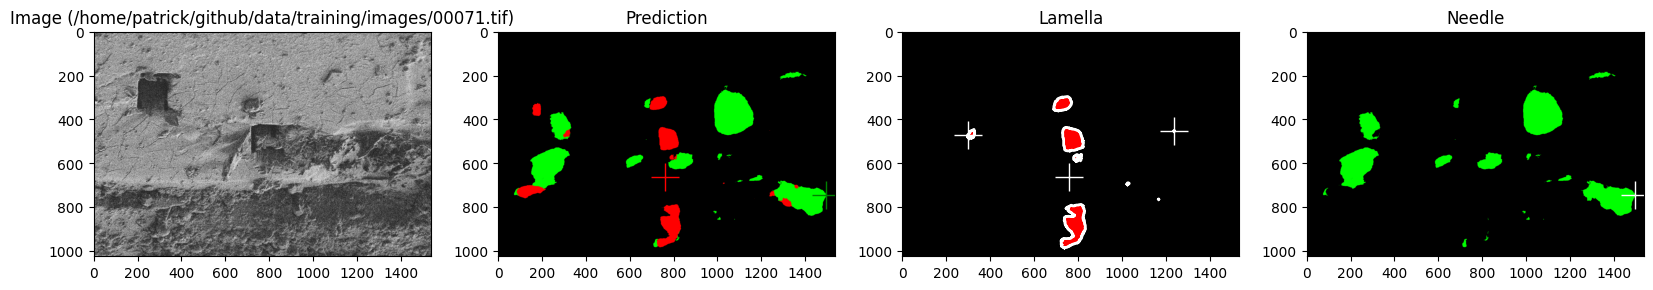

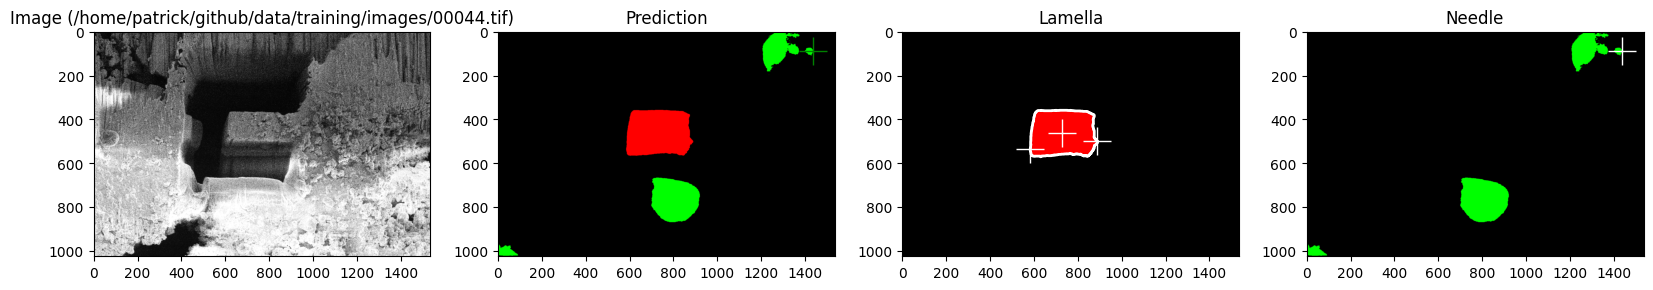

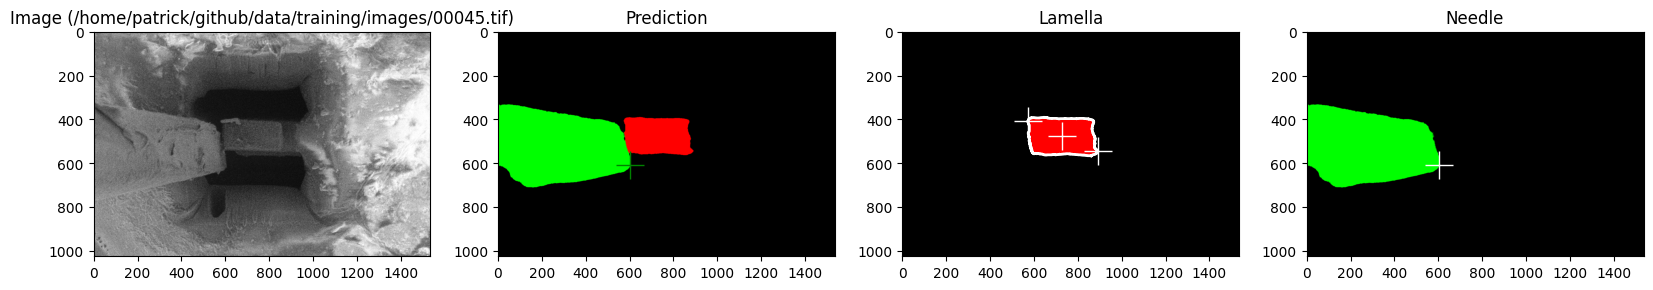

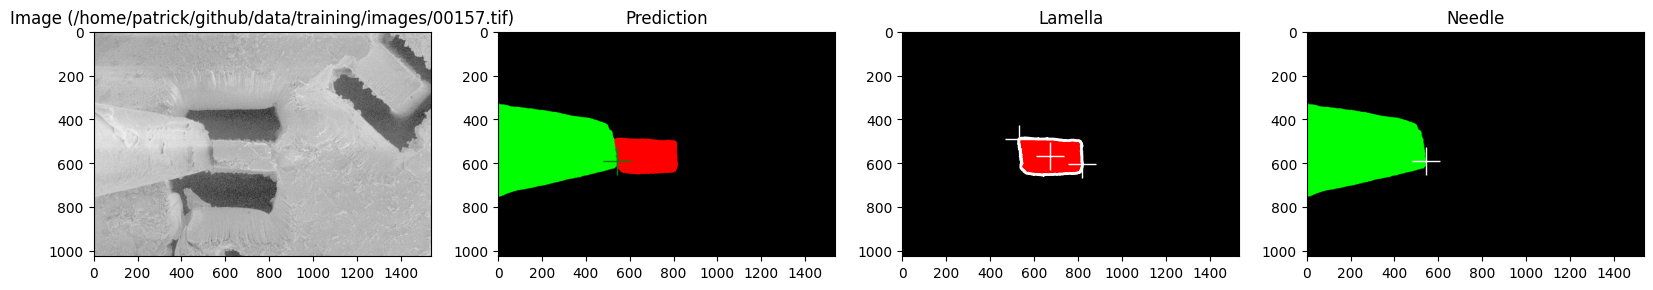

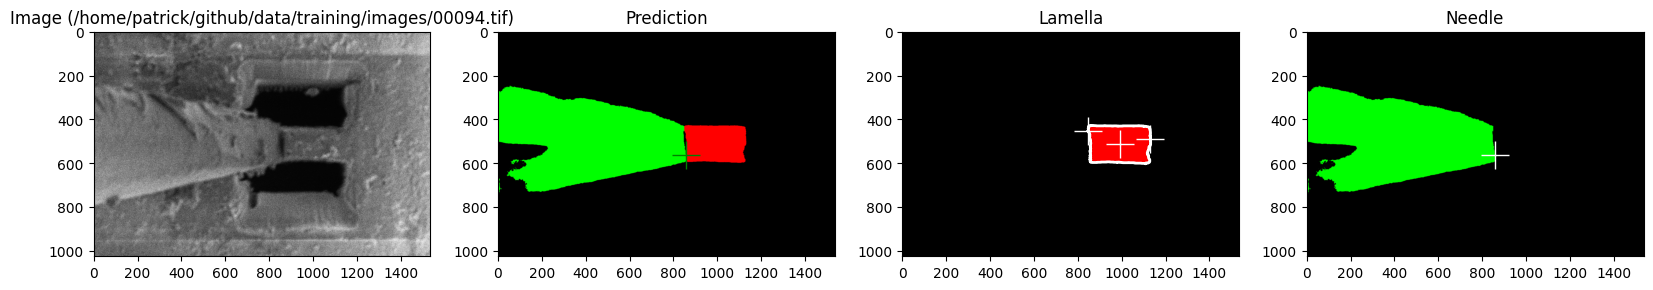

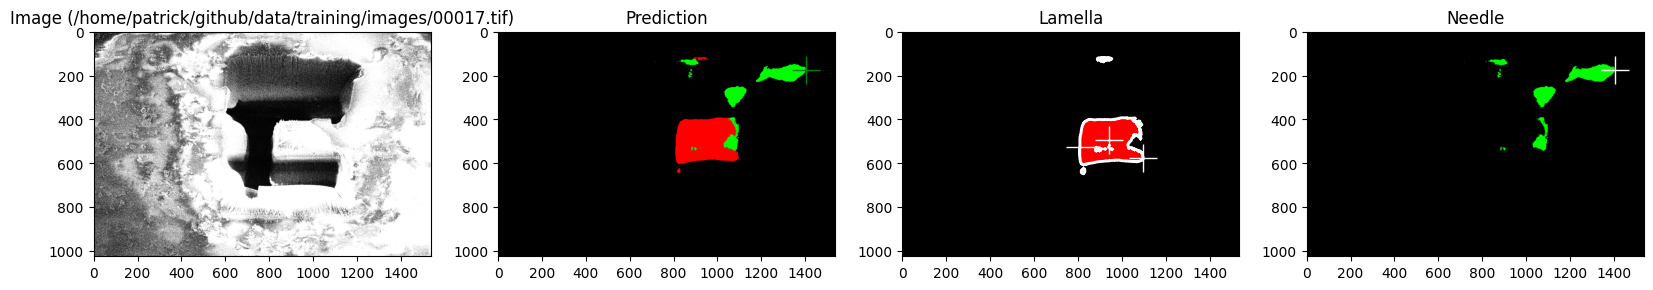

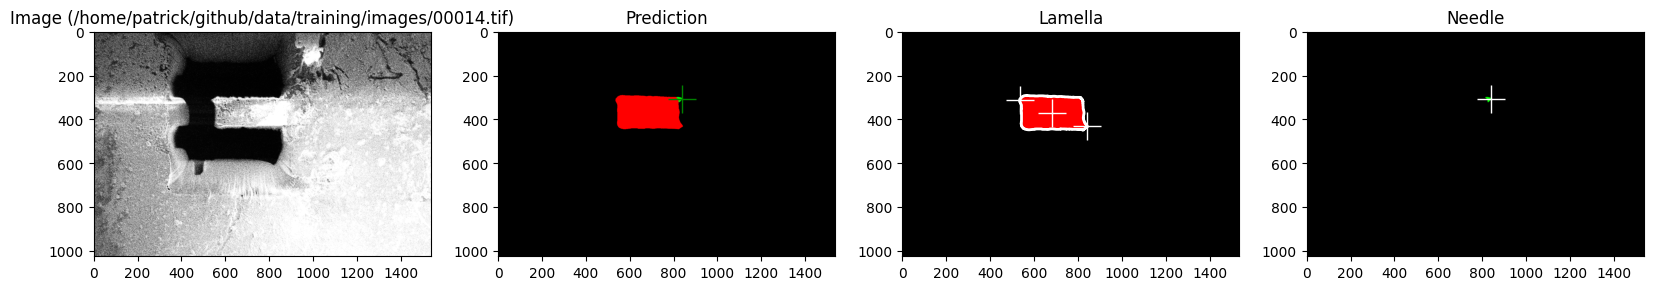

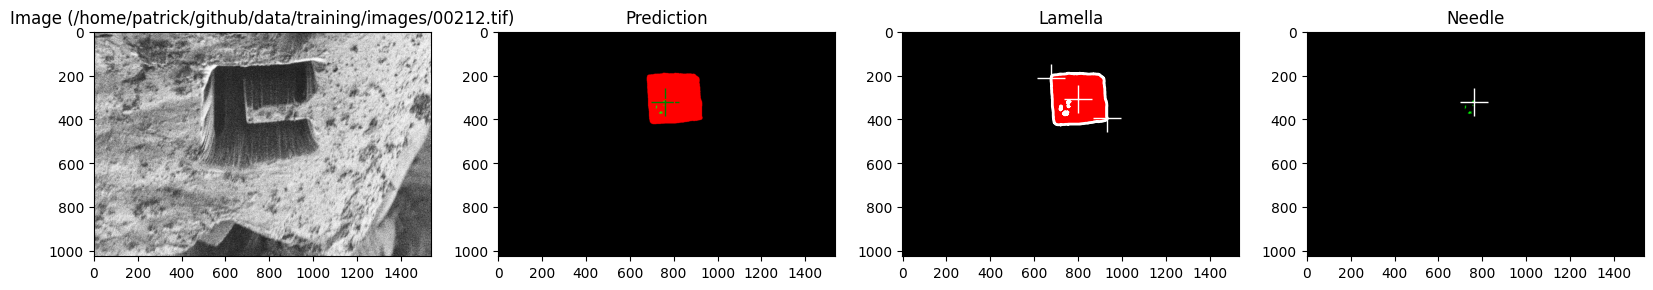

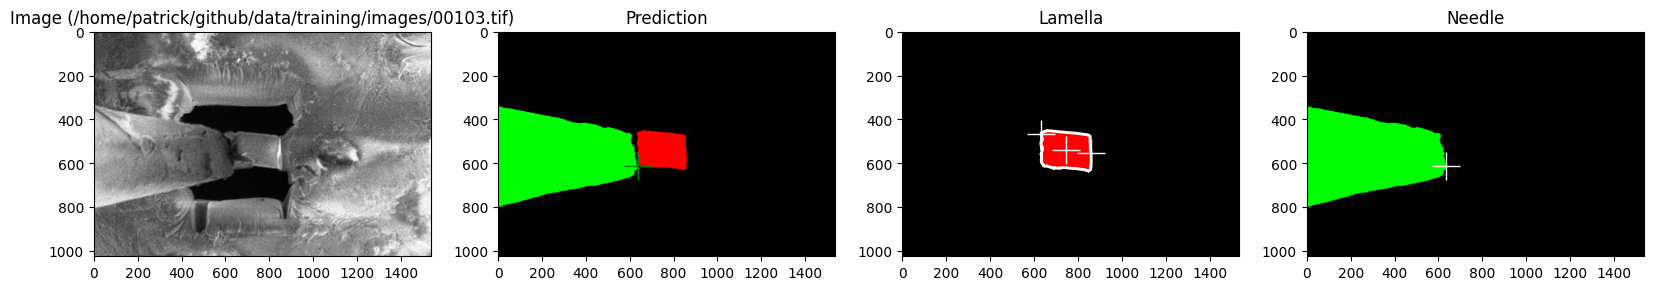

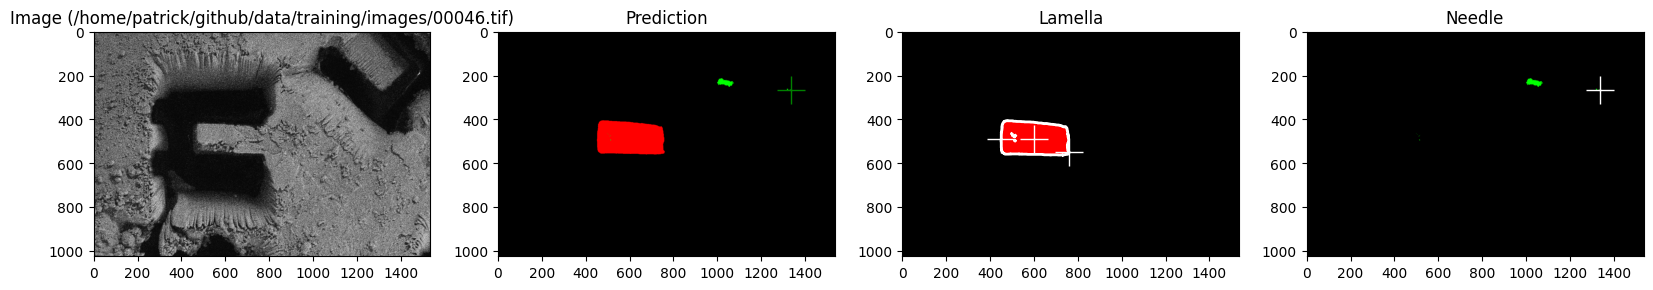

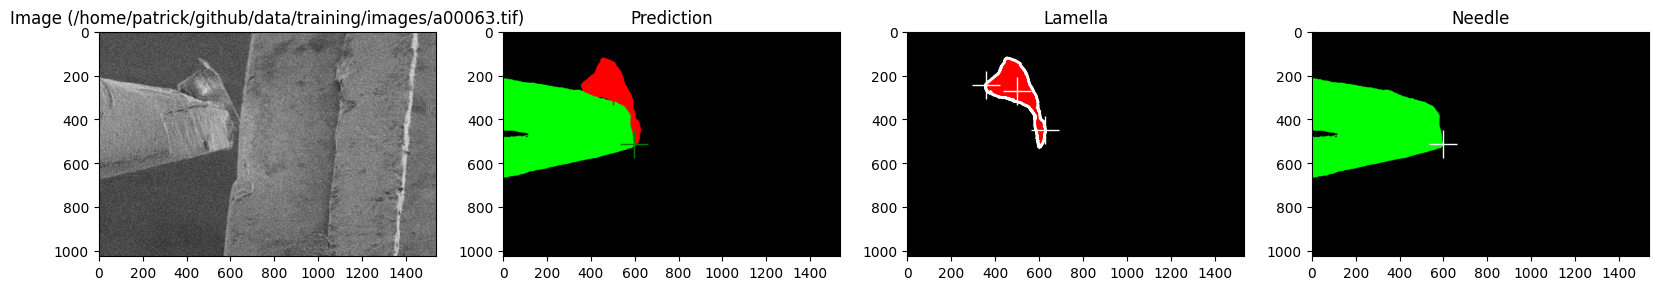

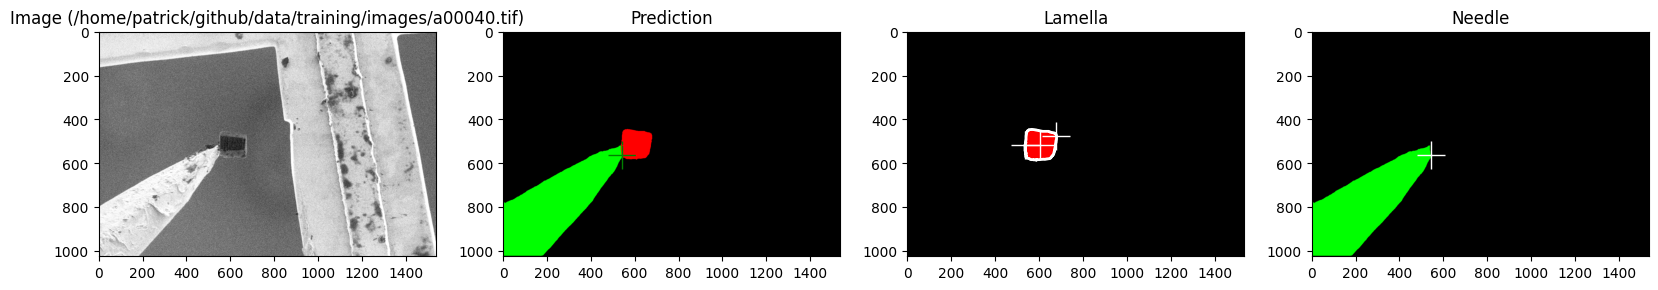

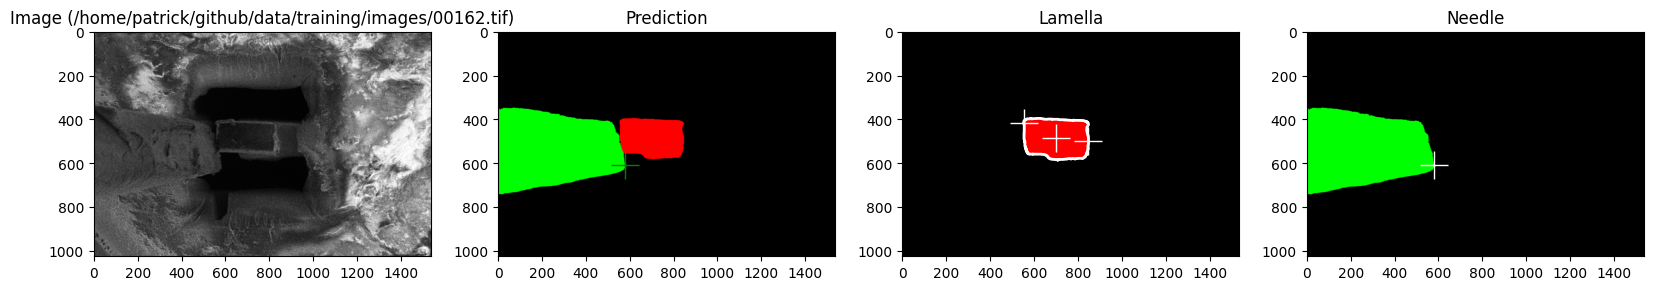

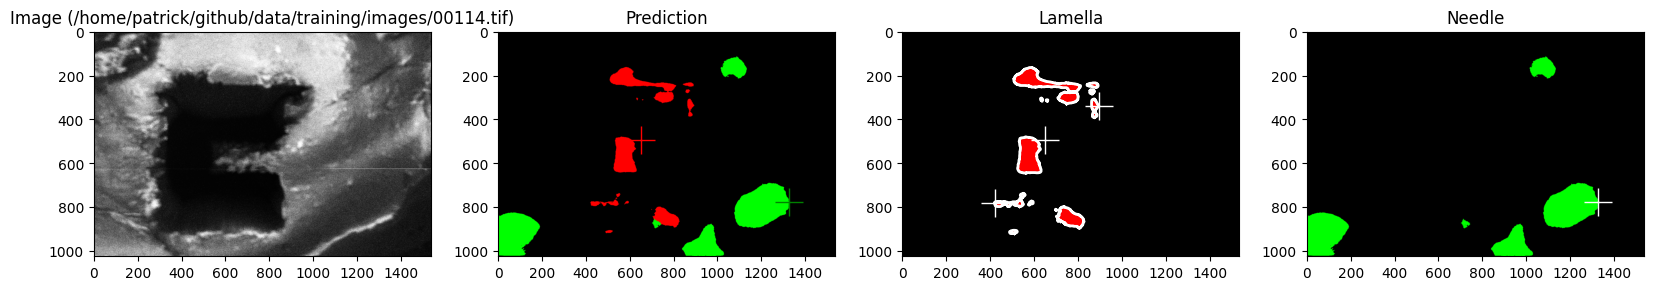

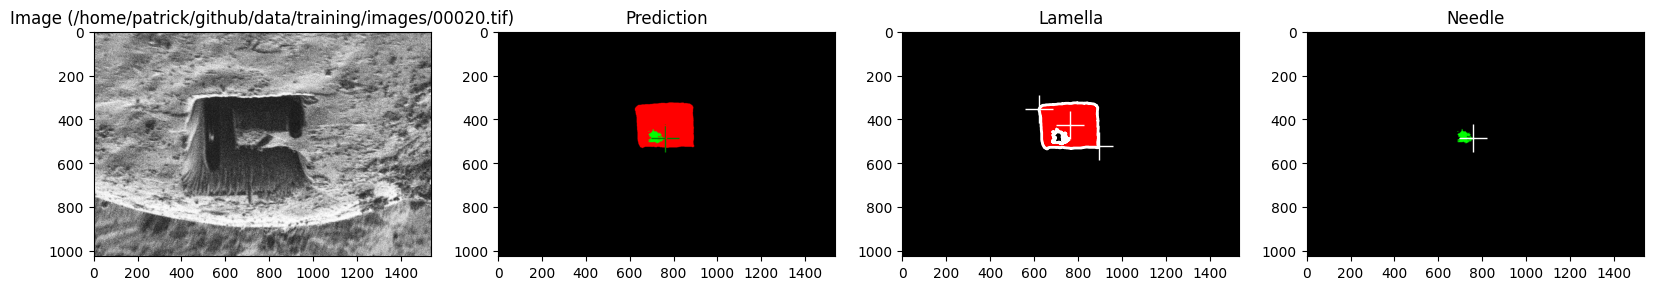

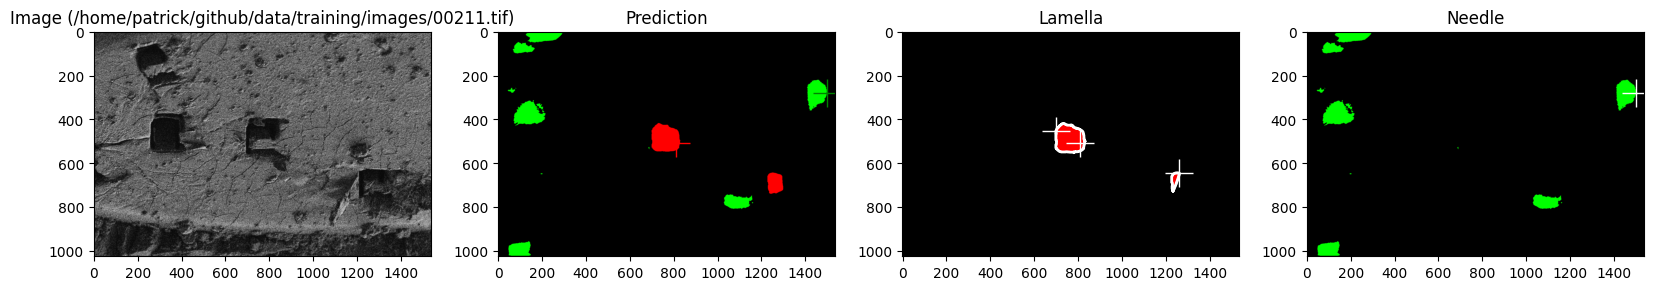

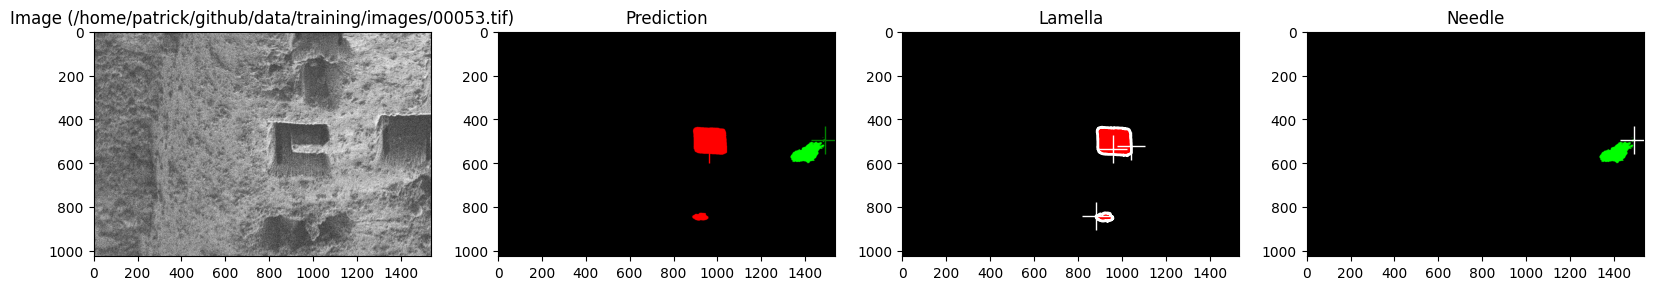

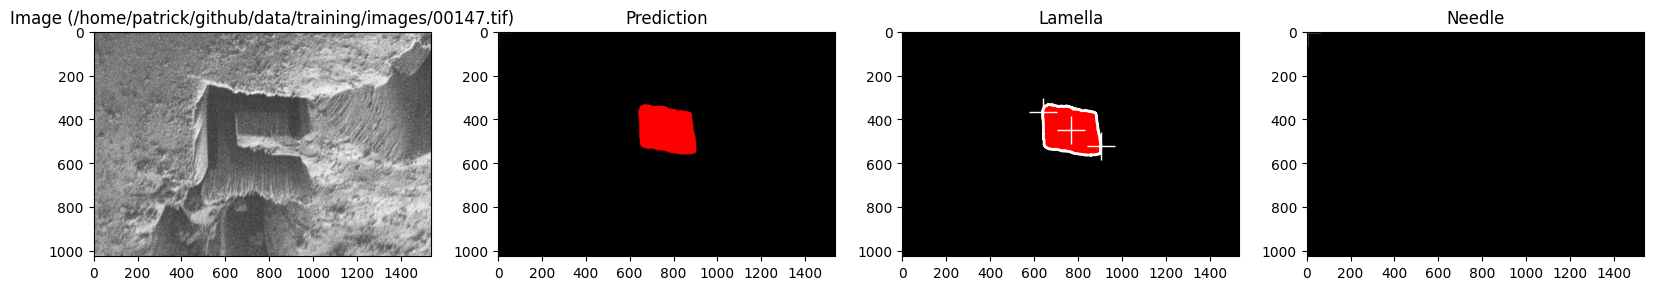

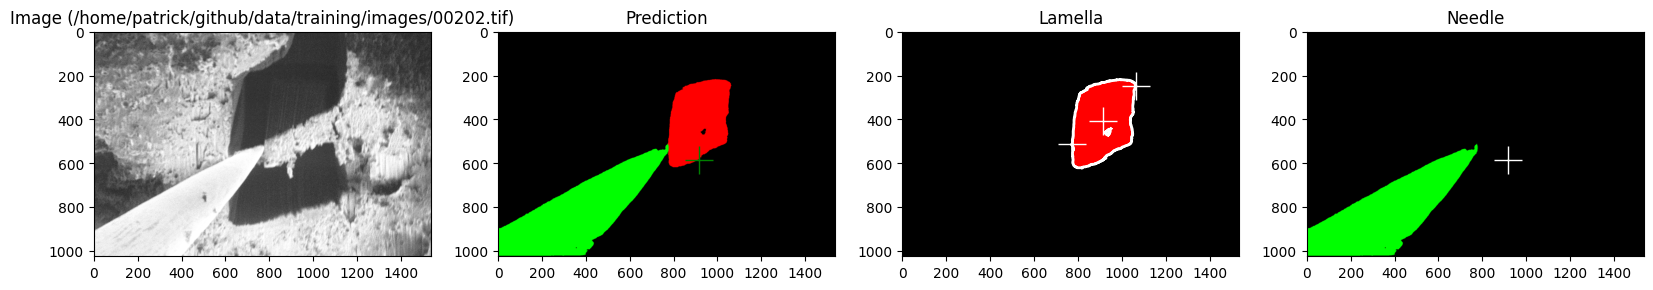

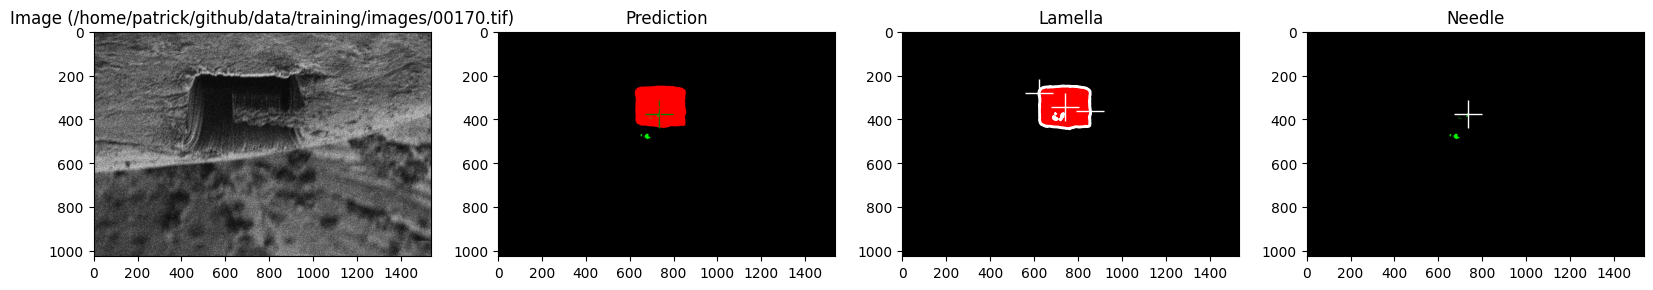

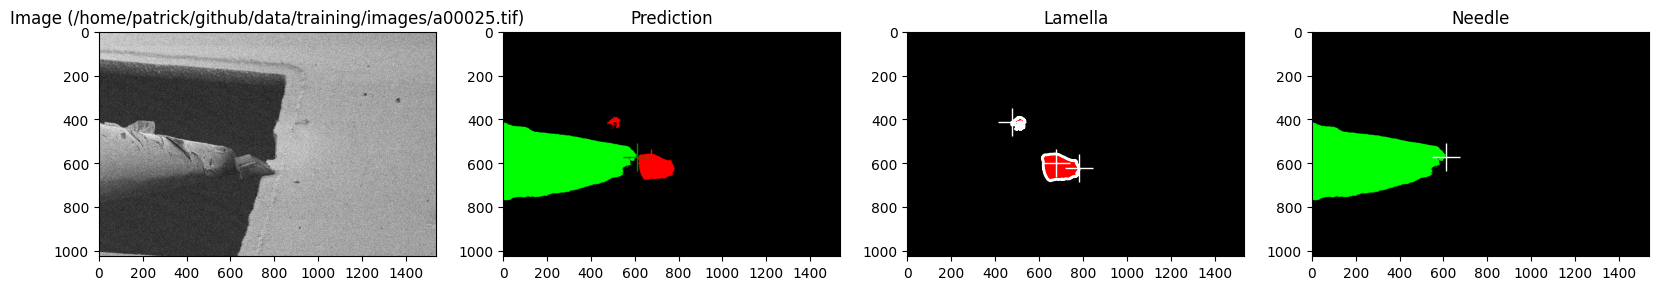

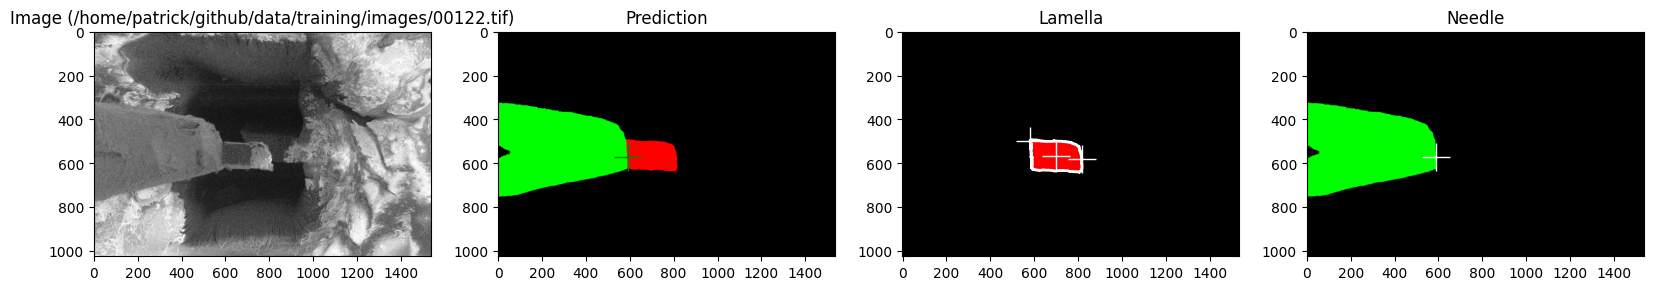

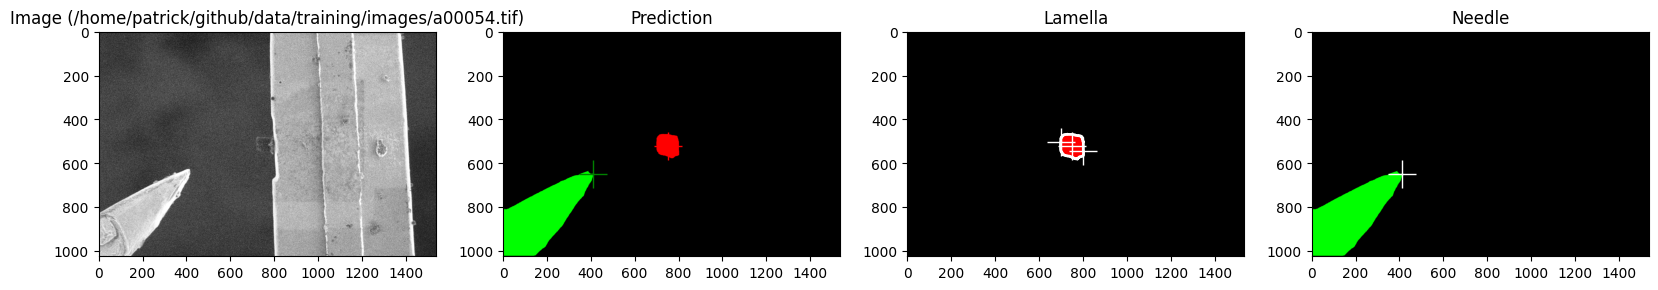

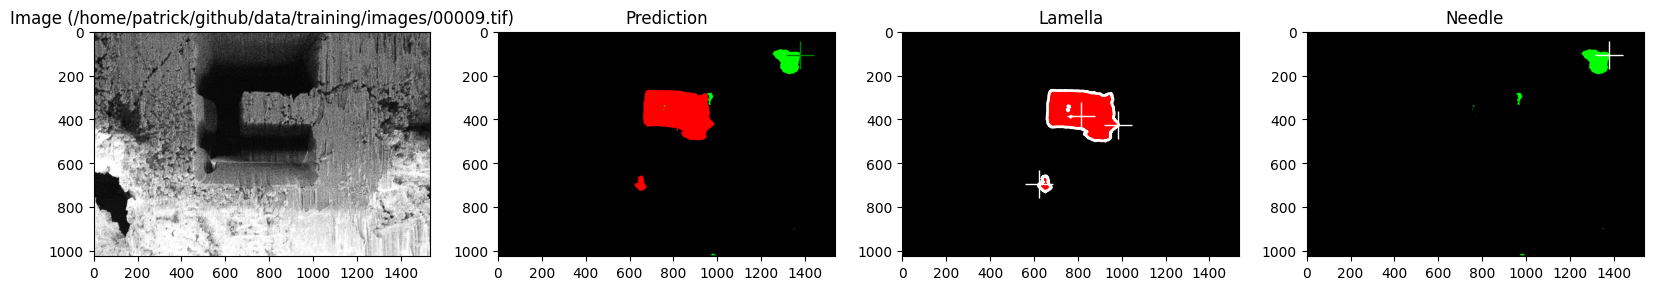

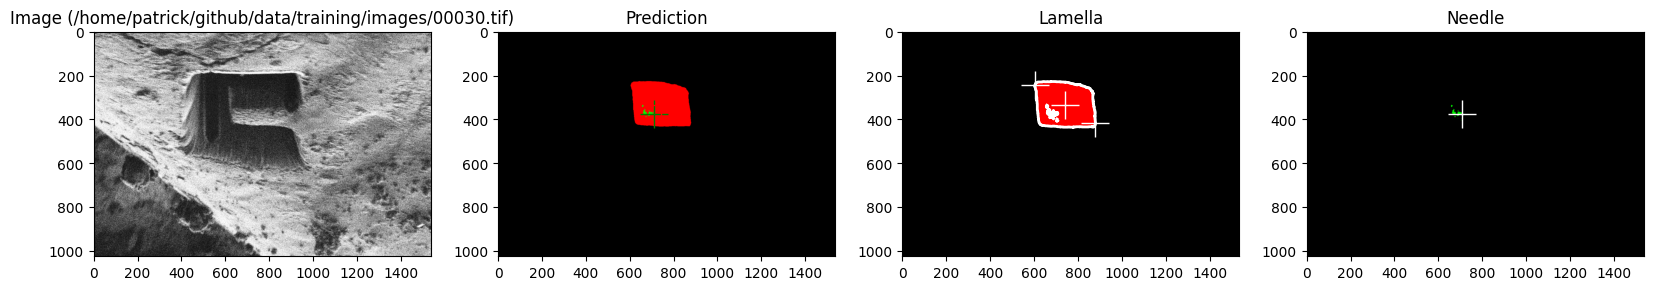

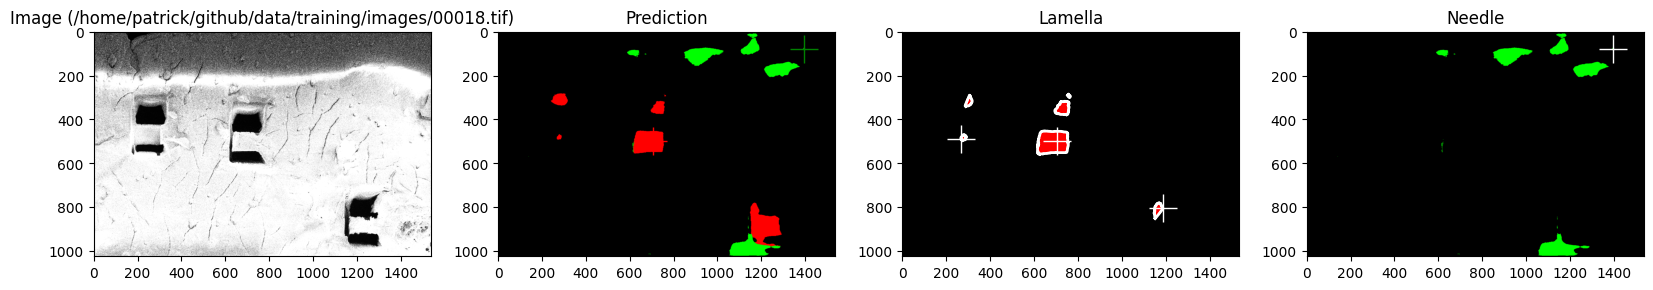

In [48]:

from random import shuffle

import numpy as np

from fibsem.imaging import masks
from fibsem.detection import detection


def to_bounding_box(contour):
    # convert a contour to bounding box (xc, yc, w, h)
    # ref : https://muthu.co/draw-bounding-box-around-contours-skimage/
    # TODO: these dimensions are backwards, swap and fix the follow up

    xmin, xmax = np.min(contour[:, 1]), np.max(contour[:, 1])
    ymin, ymax = np.min(contour[:, 0]), np.max(contour[:, 0])

    w = (xmax - xmin)
    h = (ymax - ymin)
    xc = xmin + w // 2
    yc = ymin + h // 2
    
    return [xc, yc, w, h]


shuffle(filenames)
for i, fname in enumerate(filenames):

    img = tf.imread(fname)

    # mask
    # img = masks.apply_circular_mask(img, radius=512)


    # inference
    mask = model.inference(img)

    mask = mask[0]

    # mask = masks.apply_circular_mask(mask, radius=512)
    # TODO: should these be binary?? probs easier

    # needle
    needle_mask, _ = detection.extract_class_pixels(mask, (0, 255, 0))
    needle_tip = detection.detect_corner(needle_mask)

    # lamella
    lamella_mask, _ = detection.extract_class_pixels(mask, (255, 0, 0))
    lamella_mask = masks.apply_circular_mask(lamella_mask, radius=512)
    lamella_centre = detection.detect_centre_point(lamella_mask, color=(255, 0, 0))
    lamella_right_edge = detection.detect_corner(lamella_mask, )
    lamella_left_edge = detection.detect_corner(lamella_mask, left=True)


    import skimage

    bboxes = []
    contours = skimage.measure.find_contours(lamella_mask[:, :, 0].astype(np.uint8), 0.8)

    for contour in contours:
        bboxes.append(to_bounding_box(contour))
    
    # print(bboxes)

    # centre lamella
    # lamella edges
    # needle tip


    # plot
    fig, ax = plt.subplots(1, 4, figsize=(20, 7))
    ax[0].imshow(img, cmap="gray")
    ax[0].set_title(f"Image ({fname})")
    ax[1].imshow(mask)
    ax[1].set_title("Prediction")
    ax[1].plot(needle_tip.x, needle_tip.y, "g+", ms=20, label="needle tip")
    ax[1].plot(lamella_centre.x, lamella_centre.y, "r+", ms=20, label="lamella_centre")
    ax[2].imshow(lamella_mask)
    ax[2].set_title("Lamella")
    ax[2].plot(lamella_centre.x, lamella_centre.y, "w+", ms=20, label="lamella_centre")
    ax[2].plot(lamella_right_edge.x, lamella_right_edge.y, "w+", ms=20, label="lamella_right_edge")
    ax[2].plot(lamella_left_edge.x, lamella_left_edge.y, "w+", ms=20, label="lamella_left_edge")
    for contour in contours:
        ax[2].plot(contour[:, 1], contour[:, 0], color="white", linewidth=2)

    ax[3].imshow(needle_mask)
    ax[3].plot(needle_tip.x, needle_tip.y, "w+", ms=20, label="needle tip")
    ax[3].set_title("Needle")
    plt.show()


    if i == 25:
        break
